In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import *

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res

In [101]:
## MPC only, i.e. without iCEM warmstart
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost_free, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost_point, res_point = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}")
print(f"Free space: {t_mpc_free_warm}, {cost_free} \n     Point: {t_mpc_point}, {cost_point}")
res['imp_stiff'] = params['imp_stiff']
traj_mpc = mpc.robots['point'].get_ext_state(res_point)
#print(traj_mpc['contact_1/F'][0,:])
#print(traj_mpc['F_imp'])
#print(traj_mpc['imp_rest'])

Free space cold 0.27247190475463867, Free space warm 0.09845376014709473, Point: 0.486478328704834
Free space: 0.09845376014709473, 0.752359 
     Point: 0.486478328704834, 0.20717


In [123]:
# iCEM-only result
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

time_cem_free, cost_free, res = timed_exec(mpc.icem_warmstart, params)
#print(res['imp_rest'])

cost, res = mpc.solve(params) # with an initialization

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost_point, res = timed_exec(mpc.icem_warmstart, params)
print(f"Free space: {time_cem_free}, {cost_free} \n     Point: {time_cem_point}, {cost_point}")

traj_cem = mpc.robots['point'].get_ext_state(res)
#print(traj_cem['imp_rest'])

Free space: 0.05047130584716797, 1.77434 
     Point: 0.02236342430114746, 0.685735


In [193]:

def benchmark(update_mpc_params, update_contact_params, N=10, switched = False):
    times_mean = []
    times_std = []
    cost_mean = []
    cost_std = []
    for u_mpc_params, u_contact_params in zip(update_mpc_params, update_contact_params):
        print(f'testing mpc_params {u_mpc_params} and contact_params {u_contact_params}')
        mpc, params = spawn_mpc(update_mpc_params = u_mpc_params, 
                                update_contact_params = u_contact_params,
                                switched = switched)
        q0 = params['q']
        dq0 = params['dq']
        mpc.solve(params)
        times = []
        costs = []
        for _ in range(N):
            mpc.reset_warmstart()
            params['belief_free'] = 1.0
            params['belief_point'] = 0.0 
            mpc.solve(params)

            params['belief_free'] = 0.01
            params['belief_point'] = 0.99
            params['q'] = q0+0.05*np.random.randn(7) # perturb initial state
            params['dq'] = dq0+0.3*np.random.randn(7) # perturb initial state
            tic = time.perf_counter()
            cost, _ = mpc.solve(params)
            times.append(time.perf_counter()-tic)
            costs.append(np.squeeze(cost.full()))
        times_mean.append(np.mean(times))
        times_std.append(np.std(times))
        cost_mean.append(np.mean(costs))
        cost_std.append(np.std(costs))
    return times_mean, times_std, cost_mean, cost_std

def plot_benchmark(pars, times_mean, times_std, cost_mean, cost_std, 
                   par_name = "", line_name = '',
                   fig = None, axs = None, plot_cost = False):
    
        
    if plot_cost:
        if axs is None: 
            fig, axs = plt.subplots(2,1,figsize=(6,4.5))
        
        axs[1].plot(pars, cost_mean, marker='o', label=line_name)
        mu = np.array(cost_mean)
        sig = np.array(cost_std)
        axs[1].fill_between(pars, mu-sig, mu+sig, alpha=0.5)

        axs[1].set_xlim(pars[0],pars[-1])
        axs[1].set_xlabel(par_name)
        axs[1].set_ylabel('Total cost')
    else:
        if axs is None:
            fig, ax = plt.subplots(1,1, figsize=(6,2.5))
            axs = [ax]

    mu = np.array(times_mean)/5
    sig = np.array(times_std)/5
    axs[0].plot(pars, mu, marker='o', label=line_name)
    axs[0].fill_between(pars, mu-sig, mu+sig, alpha=0.5)
    axs[0].set_xlim(pars[0],pars[-1])
    axs[0].set_xlabel(par_name)
    axs[0].set_ylabel('Solve time (sec)')
    axs[0].legend(loc='upper left')
    return fig, axs

No handles with labels found to put in legend.
<ipython-input-173-632f05c569cf>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


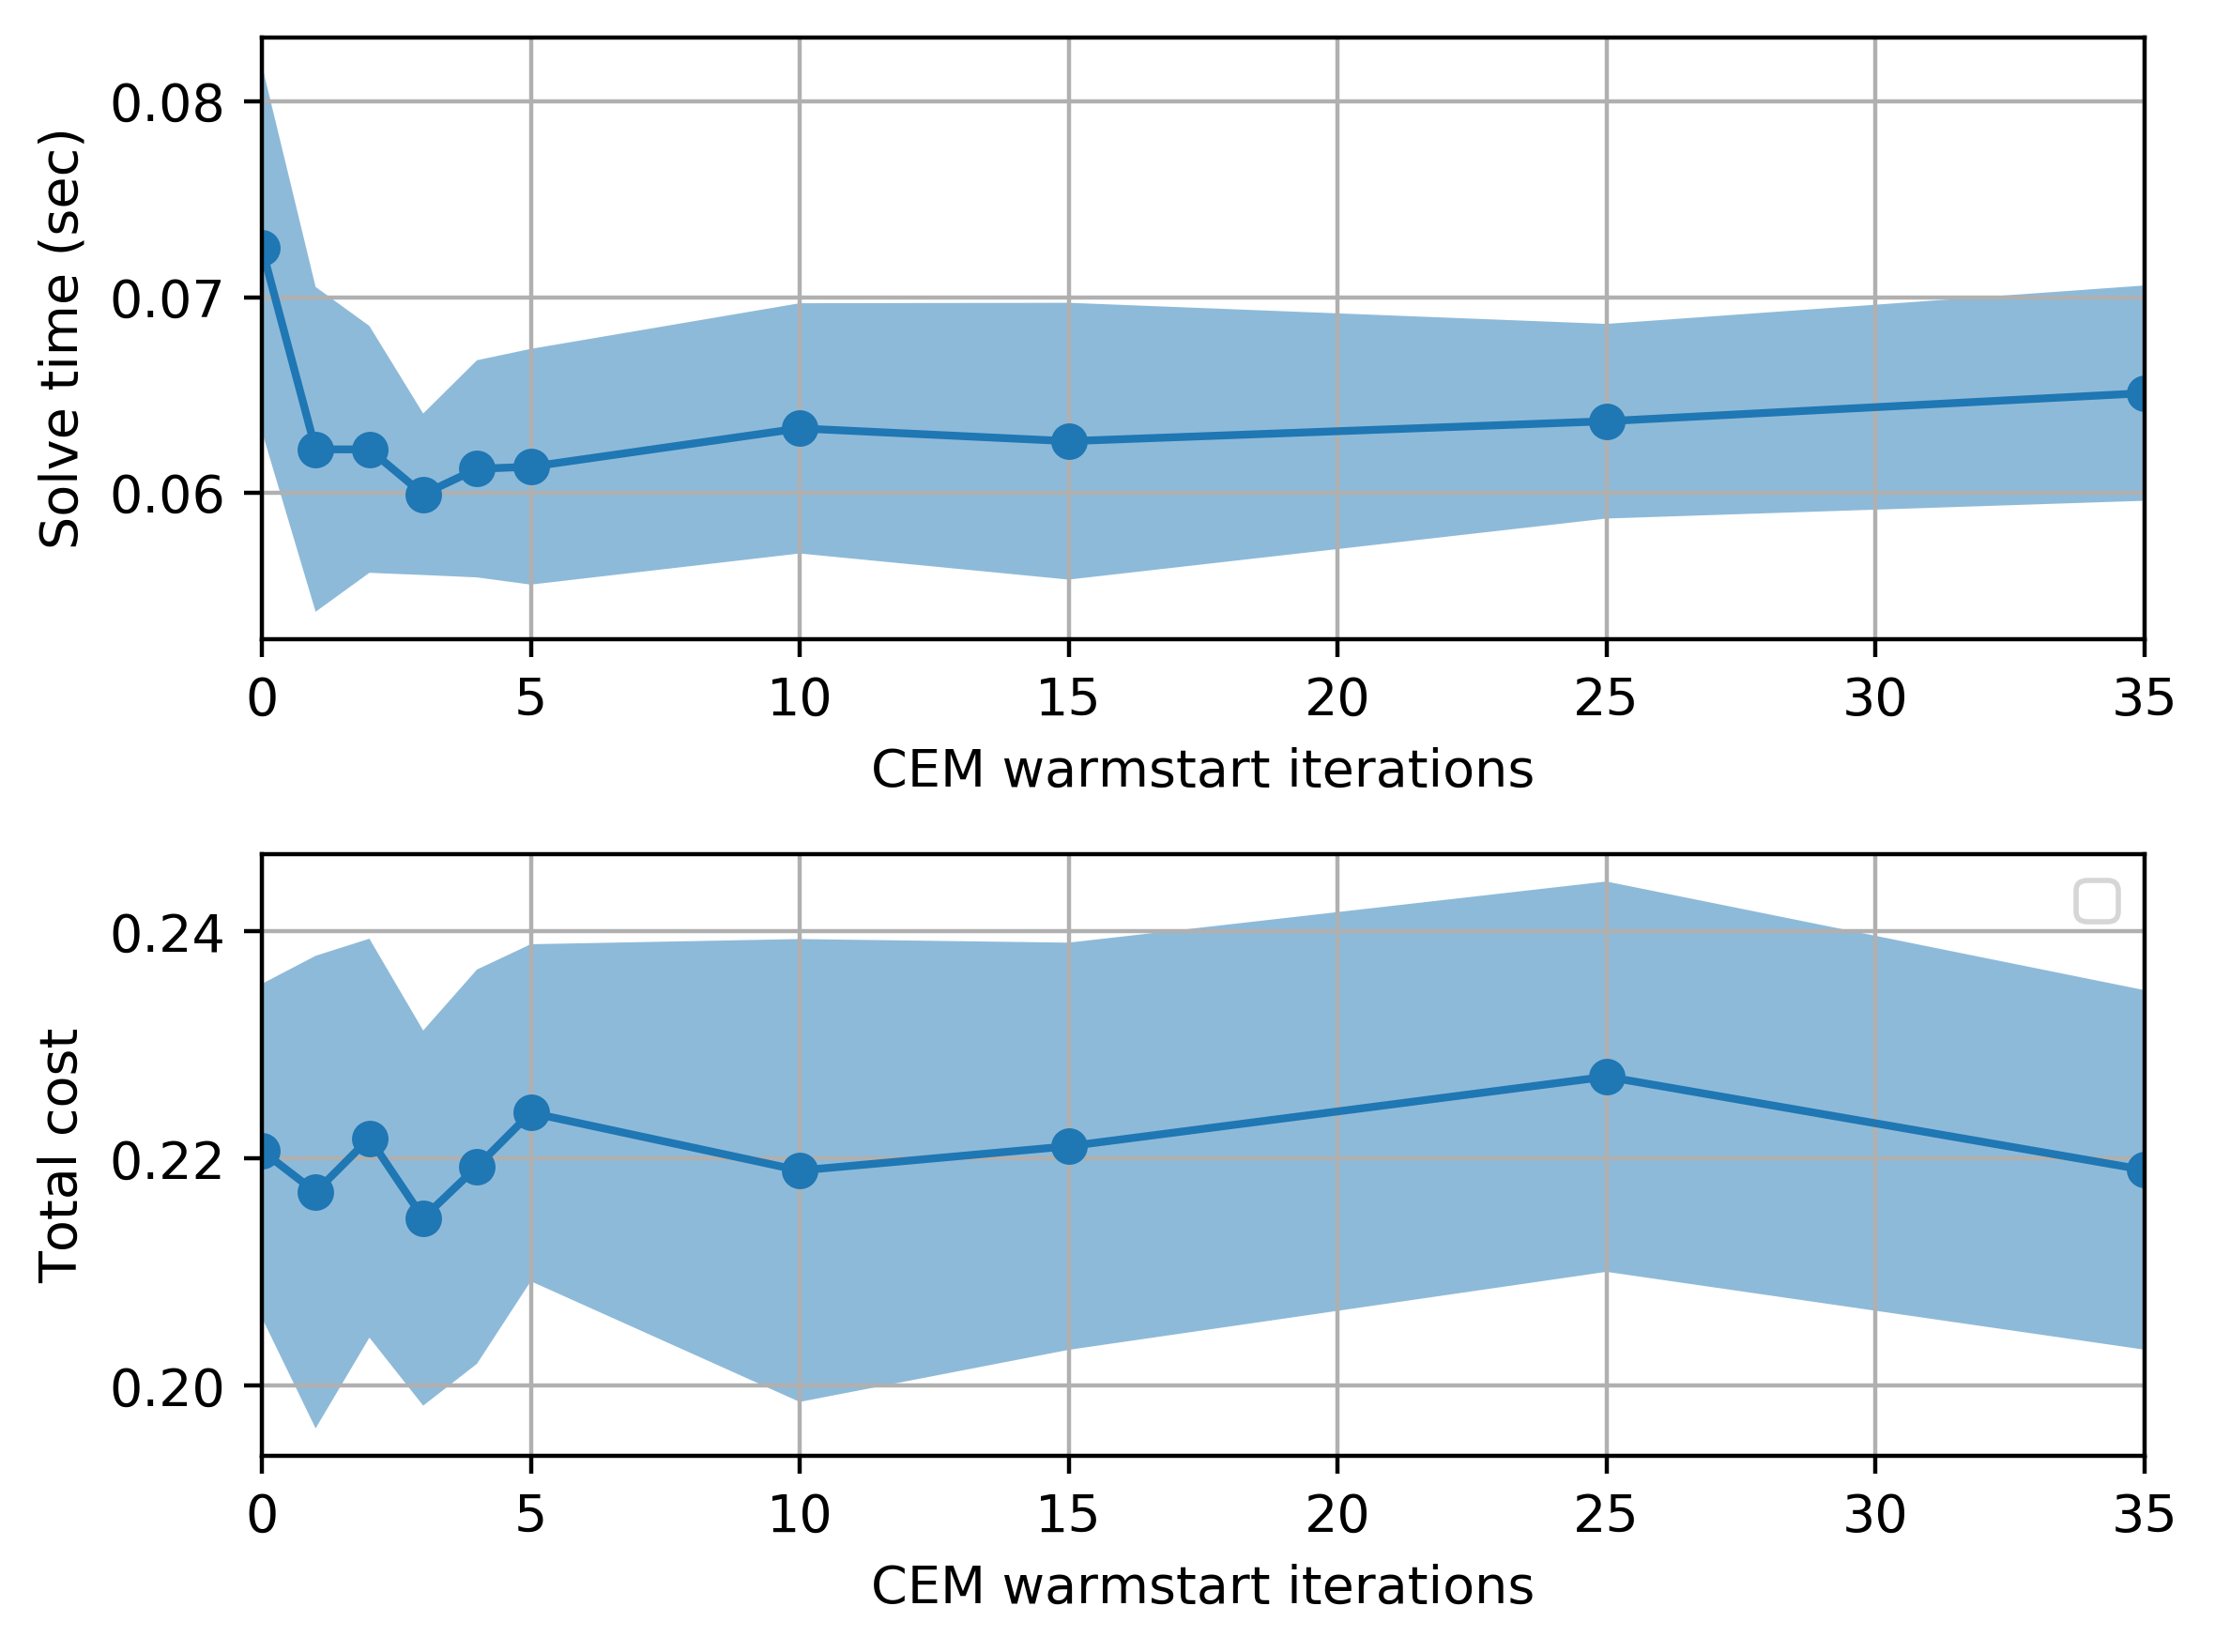

In [173]:
# Benchmark num cem iterations
from mpc import MPC
iters = [0, 1, 2, 3, 4, 5, 10, 15, 25, 35]
new_contact_params = [{}]*len(iters)
new_mpc_params = [{'num_warmstart':i} for i in iters]
res = benchmark(new_mpc_params, new_contact_params, N=30)
fig, ax = plot_benchmark(iters, *res, par_name = "CEM warmstart iterations")
plt.tight_layout()
fig.show()

plt.savefig('cem_warmstart_num_iter.pdf')

testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [300.0, 0, 0]}}}
testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [1000.0, 0, 0]}}}
testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [3000.0, 0, 0]}}}
testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [10000.0, 0, 0]}}}
testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [20000.0, 0, 0]}}}
testing mpc_params {} and contact_params {'models': {'contact_1': {'stiff': [50000.0, 0, 0]}}}
testing mpc_params {'num_warmstart': 0} and contact_params {'models': {'contact_1': {'stiff': [300.0, 0, 0]}}}
testing mpc_params {'num_warmstart': 0} and contact_params {'models': {'contact_1': {'stiff': [1000.0, 0, 0]}}}
testing mpc_params {'num_warmstart': 0} and contact_params {'models': {'contact_1': {'stiff': [3000.0, 0, 0]}}}
testing mpc_params {'num_warmstart': 0} and contact_params {'models': {'contact_1': {'stiff': [1000

<ipython-input-199-abda5dd55e70>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-199-abda5dd55e70>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


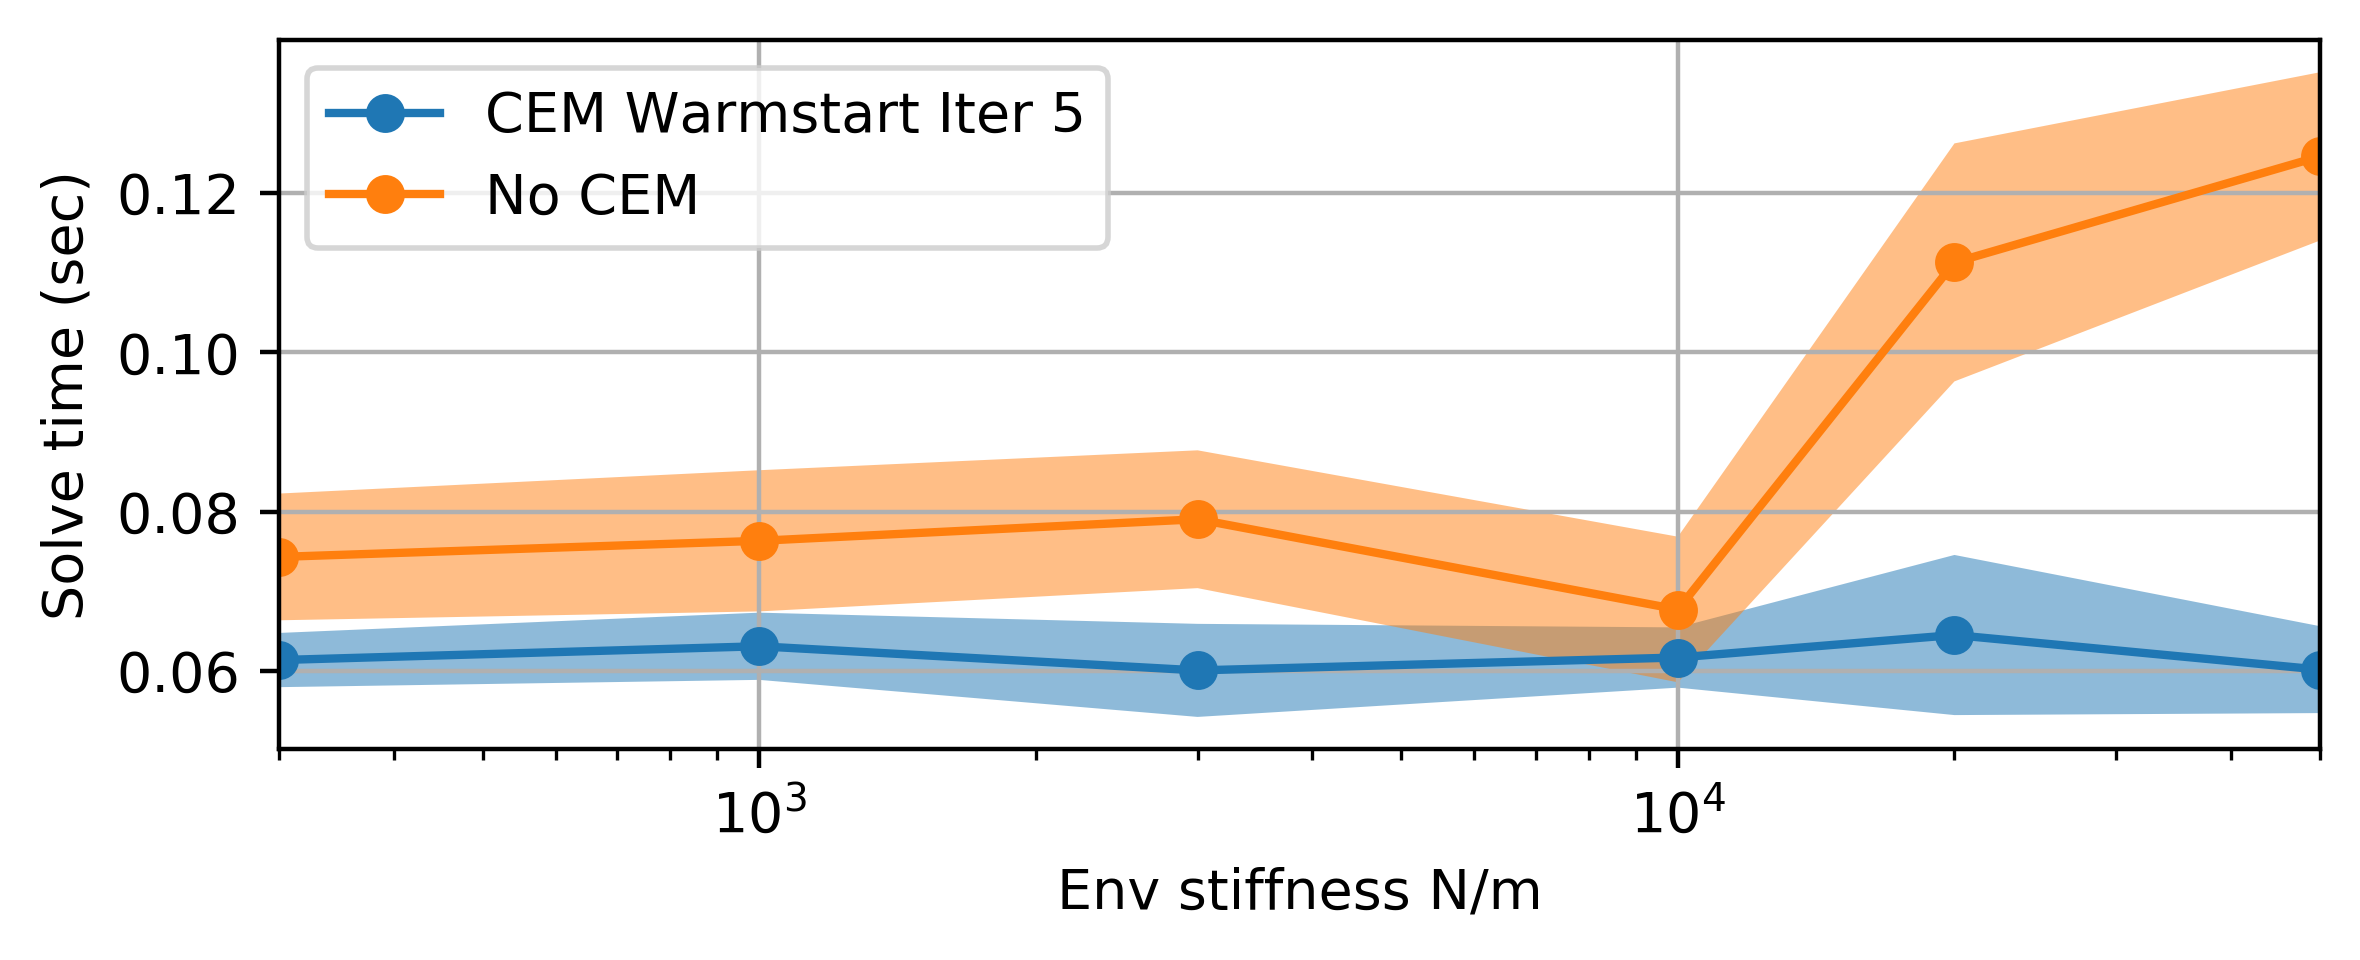

In [199]:
# Increasing stiffness, seems like at K > 2.5e3, we get relative infeasibility for the MPC and the cem warmstart helps a lot
from mpc import MPC
stiffs = [3e2, 1e3, 3e3, 1e4, 2e4, 5e4]
new_contact_params = [{'models':{'contact_1':{'stiff':[k, 0, 0]}}} for k in stiffs]
new_mpc_params = [{}]*len(stiffs)
res_s = benchmark(new_mpc_params,new_contact_params)
fig, axs = plot_benchmark(stiffs, *res_s, par_name = "Env stiffness N/m", line_name = 'CEM Warmstart Iter 5')

new_mpc_params = [{'num_warmstart':0}]*len(stiffs)
res_s2 = benchmark(new_mpc_params,new_contact_params)
fig, axs = plot_benchmark(stiffs, *res_s2, par_name = "Env stiffness N/m", line_name = 'No CEM', fig=fig, axs=axs)
fig.show()

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(stiffs[0], stiffs[-1])
#axs[1].set_ylim(0, 0.3)
plt.tight_layout()
fig.show()
fig.savefig('cem_warmstart_stiff.pdf')

<ipython-input-197-5927d3acced0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


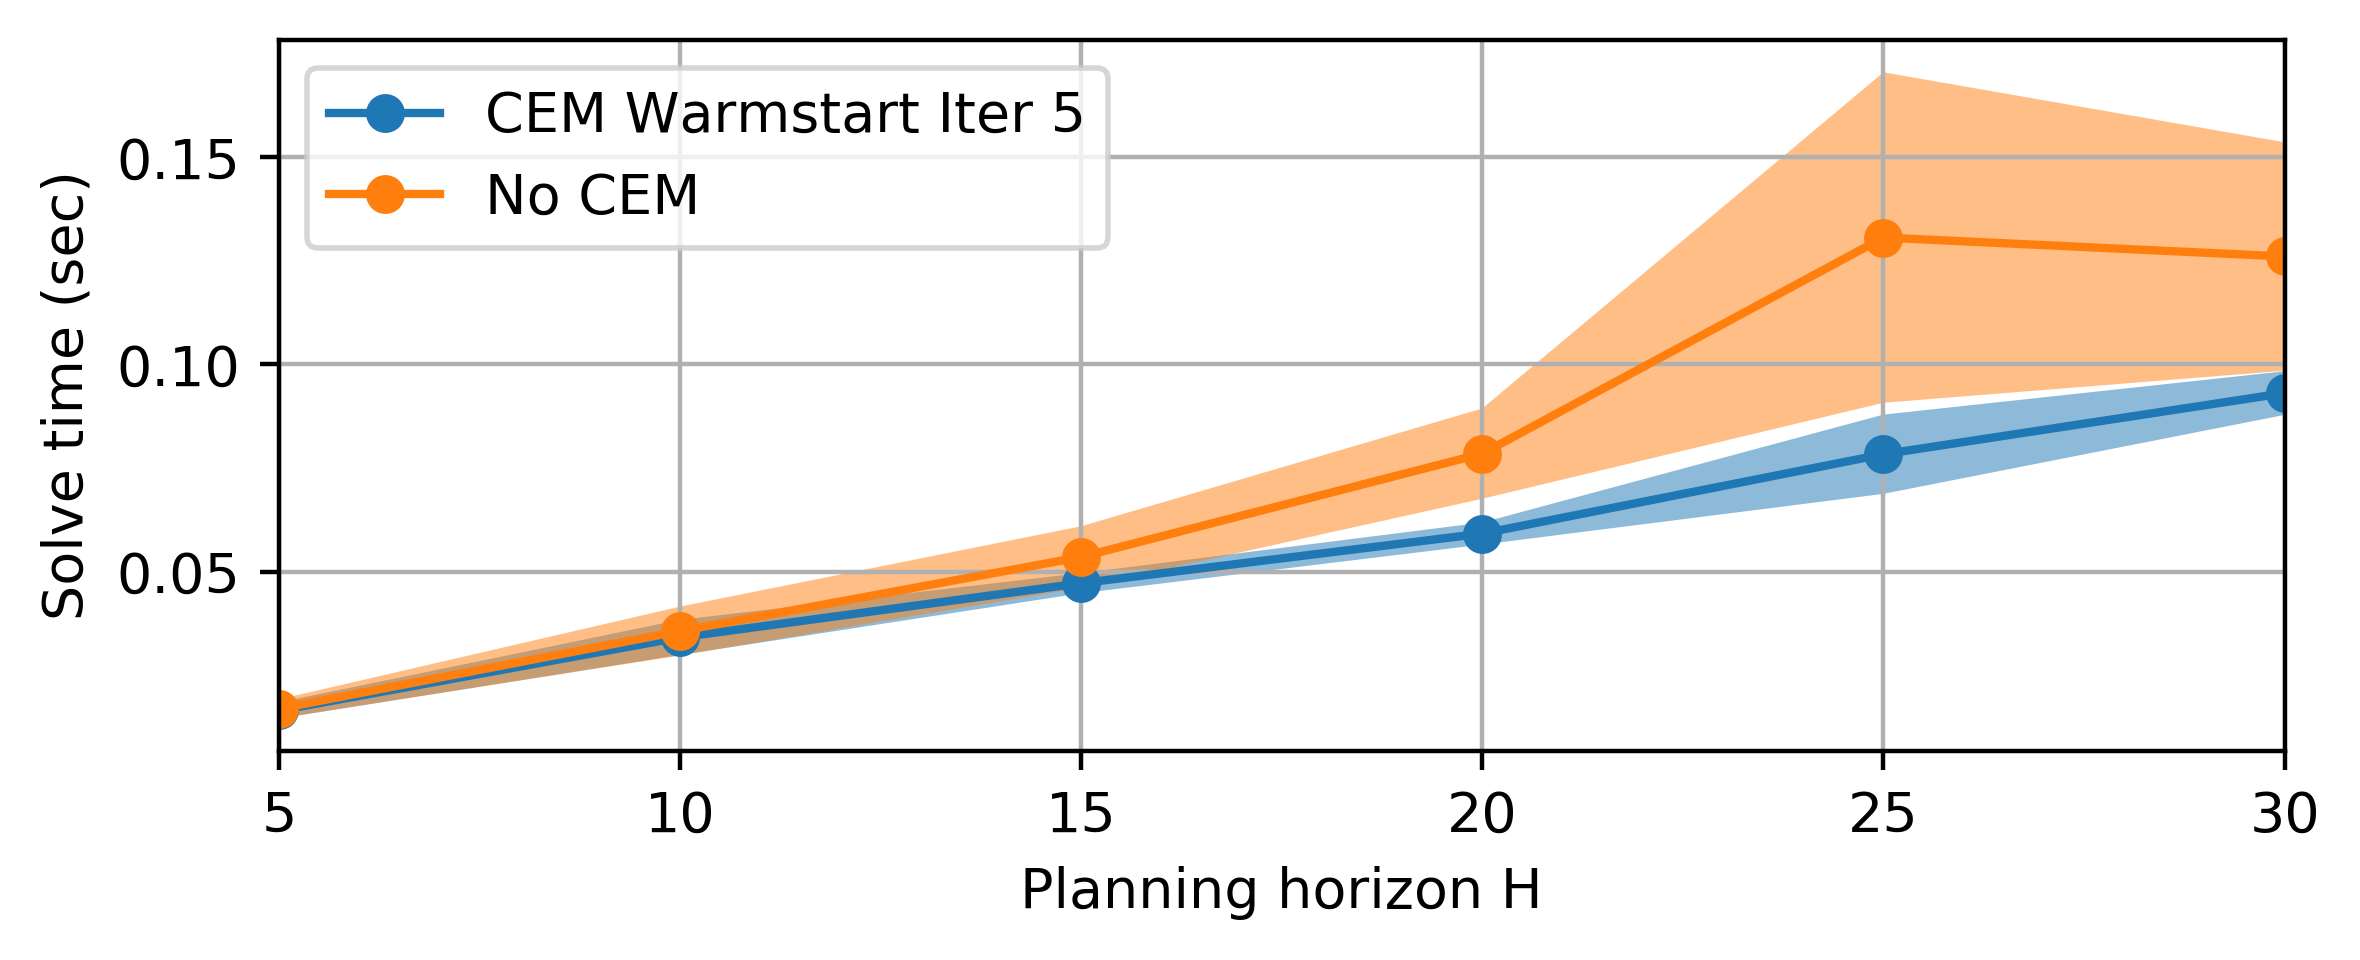

In [197]:
# Increasing planning horizon
from mpc import MPC
Hs = [5, 10, 15, 20, 25, 30]
new_contact_params = [{}]*len(Hs)
new_mpc_params = [{"H":H} for H in Hs]
#res_h = benchmark(new_mpc_params,new_contact_params)
fig, axs = plot_benchmark(Hs, *res_h, par_name = "Planning horizon H", line_name = 'CEM Warmstart Iter 5')

new_mpc_params = [{"H":H, 'num_warmstart':0} for H in Hs]
#res_h2 = benchmark(new_mpc_params,new_contact_params)
fig, axs = plot_benchmark(Hs, *res_h2, par_name = "Planning horizon H", line_name = 'No CEM', fig = fig, axs = axs)

fig.show()
plt.tight_layout()
plt.savefig('cem_warmstart_H.pdf')

testing mpc_params {'num_warmstart': 0} and contact_params {}
testing mpc_params {'num_warmstart': 1} and contact_params {}
testing mpc_params {'num_warmstart': 2} and contact_params {}
testing mpc_params {'num_warmstart': 3} and contact_params {}
testing mpc_params {'num_warmstart': 4} and contact_params {}
testing mpc_params {'num_warmstart': 5} and contact_params {}
testing mpc_params {'num_warmstart': 10} and contact_params {}
testing mpc_params {'num_warmstart': 15} and contact_params {}


<ipython-input-76-7e20f53c4e84>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


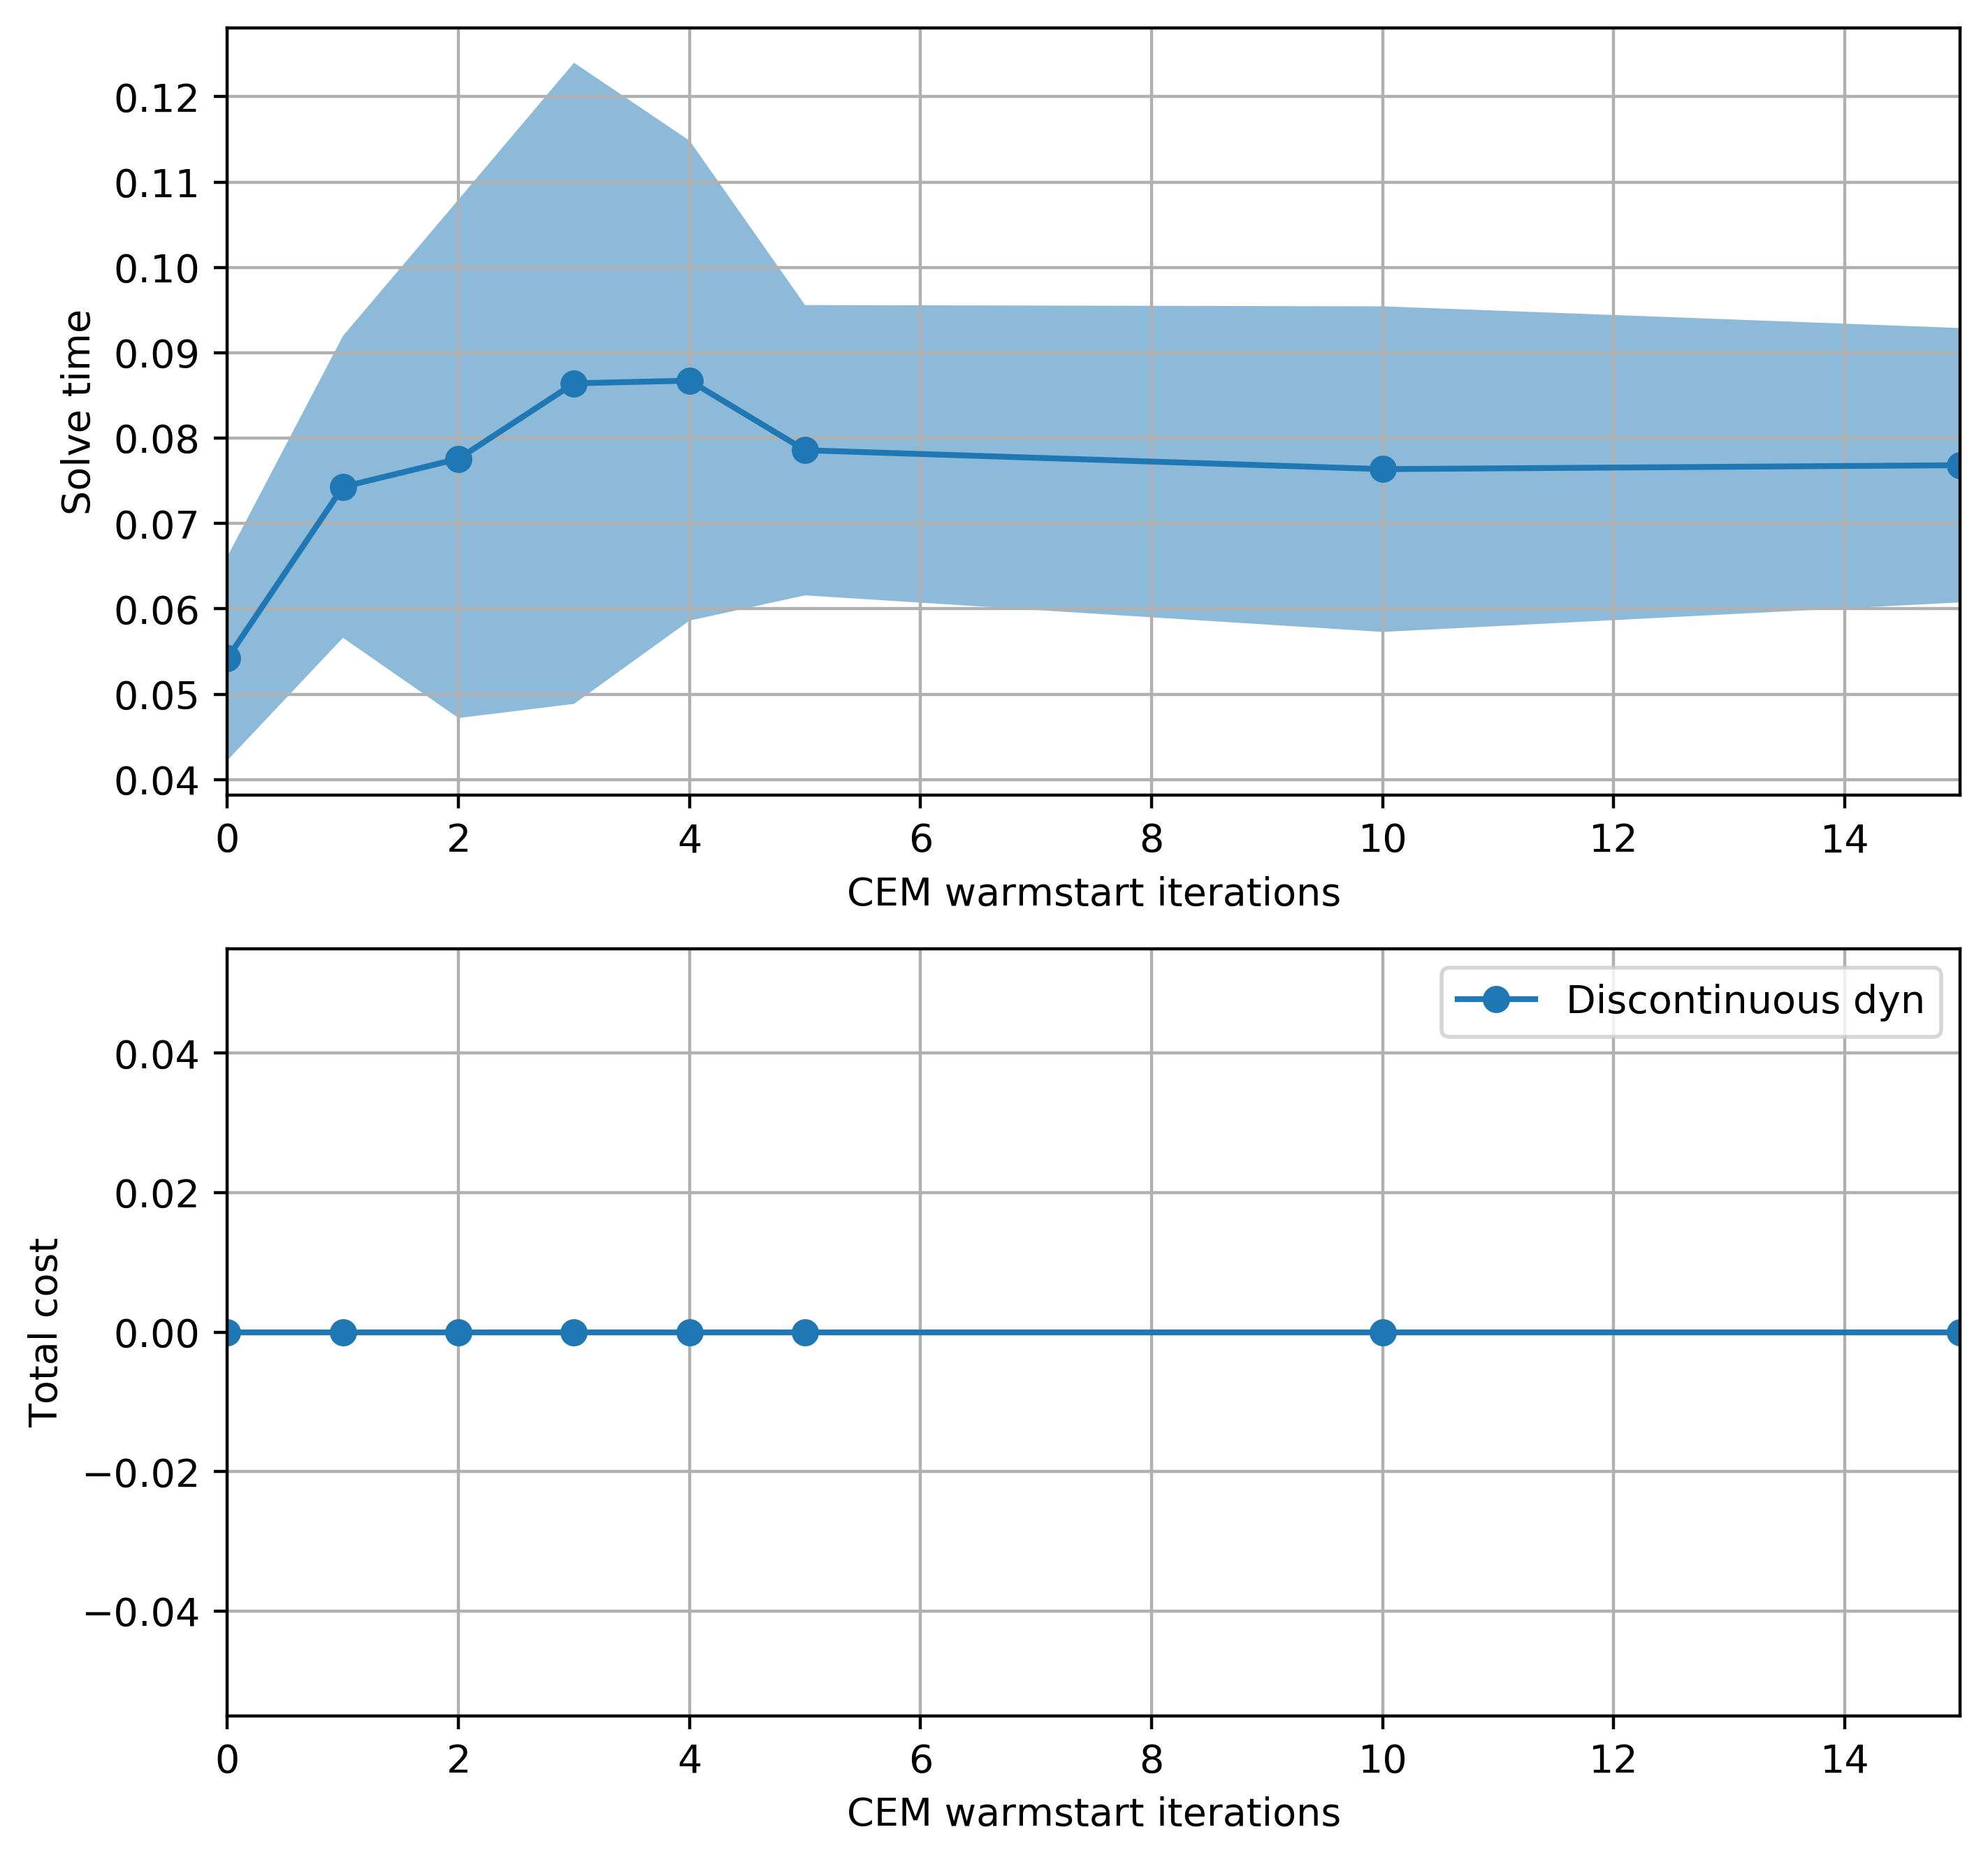

In [76]:
# Switched model, also does well 
from mpc import MPC
iters = [0, 1, 2, 3, 4, 5, 10, 15]
new_contact_params = [{}]*len(iters)
new_mpc_params = [{'num_warmstart':i} for i in iters]
res = benchmark(new_mpc_params,new_contact_params, switched = True)
fig, axs = plot_benchmark(iters, *res, par_name = "CEM warmstart iterations", line_name = 'Discontinuous dyn')
fig.show()

In [84]:
mpc, params = spawn_mpc(switched=True)
params['belief_free'] = 1.0
cost, res = mpc.solve(params)
traj = mpc.robots['free'].get_ext_state(res)
print(cost)
print(traj['imp_rest'])
print(traj['contact_1/F'])

0.775157
[[0.22585281 0.38616223 0.35661655 0.34155982 0.33224542 0.32540791
  0.31973837 0.31472914 0.31020768 0.30613046 0.30249338 0.29929736
  0.29653888 0.29420939 0.29229268 0.2907429  0.28939783 0.28769112
  0.28375164 0.27162876]
 [0.15652955 0.26255896 0.20697662 0.19293784 0.19229793 0.19653504
  0.20292852 0.21047834 0.21870081 0.22727929 0.23596745 0.24456427
  0.25290809 0.26087671 0.26839535 0.27546604 0.28225578 0.28934606
  0.29842964 0.31427646]
 [0.91183426 0.35315414 0.40621793 0.44244882 0.47151232 0.49688556
  0.51993697 0.54123536 0.56105187 0.57956278 0.596927   0.61330959
  0.62888262 0.64381653 0.65826514 0.67233934 0.68605111 0.69917358
  0.71085013 0.71841191]]
[[-211.12924004 -169.32160768 -145.44245887 -128.85783132 -115.43851073
  -103.51017473  -92.48780156  -82.2362235   -72.76474123  -64.09762046
   -56.23204707  -49.13414864  -42.74795598  -37.00613819  -31.83840605
   -27.17605422  -22.95001086  -19.072973    -15.375195    -11.40132781]
 [   0.       